<h3 align="center">NEU 437/537</h3>
<h4 align="center">Princeton University, Spring 2022</h4>

---
## Homework 4: Reinforcement Learning
#### Due: Friday, Apr 29

---
### Formatting Instructions
- Please prepare your homework submission completely within your own copy of this colab notebook.

- For each problem or sub-problem, please **limit yourself to one Code cell and/or one Markdown cell** as appropriate (switch between them by using the menu at the top, or the shortcuts `Ctrl+M M` for Markdown and `Ctrl+M Y` for Code). 

- **Submitting your homework**:  Please submit an .ipynb file via the assignment tab in Canvas. (From your notebook, File->Download->Download .ipynb).  Late submissions will be penalized 10% per day.

- **Test before submmitting**: Before submitting, make sure to verify that your code runs without  errors by selecting `Runtime -> Restart & Run All`. 


---
Setup: let's run a magic command (to force inline plotting) and then import some of our favorite packages.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In this problem set, you will explore 2 types of reinforcement learning problems: multi-armed bandits and Markov Decision Processes. 

Reinforcement learning is learning what to do (i.e. how to make decisions) to maximize a numerical reward signal. Unlike in supervised learning, the learner is not told the correct answer, but must discover "good" decisions by trial and error. 

Thus, one of the main elements of a reinforcement learning system is a reward signal. The reward signal defines the goal of a reinforcement learning problem. On each time
step, the environment sends to the reinforcement learning agent a single number called
the **reward**. The agent’s sole objective is to maximize the total reward it receives over
the long run. 

## Plotting notes

Whenever you are asked to plot anything, make sure you provide labels (axes, legends, etc.) where appropriate. 

# Question 1: A $k$-armed Bandit Problem

Consider the following problem. Suppose you are given  $k$ different options, or actions, to choose from, and every time step, you have to select 1 action among these $k$ options. After each choice you receive a numerical reward chosen from a fixed probability distribution that depends on the action you selected. For example, you might be faced with $k$ slot machines in a casino, each of which will give you a random reward (but drawn from a fixed probability distribution, particular to each slot machine). Your goal is to maximize the expected total reward over some time period.

**1a**. Create 10 "bandits", which we will model with random number generators. Each generator (i.e., each bandit) draws numbers from a normal distribution, with mean $\mu$ and variance 1. First create the means for each bandit by sampling their means $\mu_a$ from a normal distribution with mean 0 and variance 5:
$$\mu \sim \mathcal N(0, 5)$$
 Then create a function, such that when you call that function and pass it a particular $\mu_a$, you receive a real number output, the result of an encounter with that bandit. This simulates a slot machine that you can "call" for reward. i.e. The reward $R_t$ that you will receive at time $t$ will be
 $$ R_t \sim \mathcal N(\mu_a, 1)$$
where $\mu_a$ is the mean of the bandit $a$ that you chose.

 Historical Note: These are called $k$-bandit problems in the reinforcement learning literature. "The name comes from imagining a gambler at a row of slot machines (sometimes known as 'one-armed bandits'), who has to decide which machines to play, how many times to play each machine and in which order to play them, and whether to continue with the current machine or try a different machine." 

 Source: Wikipedia https://en.wikipedia.org/wiki/Multi-armed_bandit

<font color="red"> Your answer in code </font>

**(2 points)**


In [2]:
def set_bandits(mu_a_var=5, k=10, seed=0):
    '''
    
    sets k arms bandit
    
    input
        mu_a_var (int) variance for arms
        k (int) number of arms
        
    returns 
        mean of arms
    '''
    np.random.seed(seed) ## consistent bandits
    arms_means = np.random.normal(0, mu_a_var, size=k)
    
    return arms_means
    
def get_bandit_reward(a, arms_means):
    '''
    get bandit reward from a k arms bandit
    
    get
        a (int) selected arm 
    returns 
        reward for action a
        
    '''
    np.random.seed(None) ## Random rewards based on params
    return np.random.normal(arms_means[a], 1)

## example
arms_means = set_bandits()
arm=1
get_bandit_reward(arm, arms_means)


4.4301957903132845

**1b**. Suppose you are the creator of these bandits (which you are), so that you know everything there is to know about the bandits in advance (except for the random sequence generated by each bandit). There is an optimal strategy (in terms of maximizing your reward rate) for how to choose among the bandits, called the **greedy strategy**. 
* Describe this strategy.

<font color="red"> Greedy algorithms make a locally optimal choice at each step given the available knowledge. They do not necessarily result in the optimal solution overall but will continue to choose the best current action.</font>

* Why is this strategy called the greedy strategy? **(2 points)**

<font color="red"> I believe it is called 'greedy' since it only takes into account the immediate reward rather than considering the larger problem. An agent that would consider it, may be willing to compromise to achieve an overall better solution. But, a greedy algorithm will opt in for the best current choice instead.</font>



**1c**. Suppose that you do
not know anything about the bandits. You can only "query" each bandit to see the reward $R_t$ it will give you at time $t$. To select the best action here, you can use an  **action-value
function**, which specifies the average amount of reward the agent will receive by selecting an action $a$ is
$$q_{*}(a) = \mathbb{E}\left[R_{t} \mid A_{t}=a\right]$$
$\mathbb{E}$ is the expected value, $A_t$ is the action at time $t$ (i.e. when bandit $a$ is chosen).



* Since you don't know anything about these bandits, we have to *estimate* the true action-value function $q_{*}(a) $ for each action $a$. Describe how you can do this. Let us call this estimate $Q_{t}(a)$. **(2 points)**

Note that when you have $N$ bandits, you have $N$ possible choices $a$, and therefore you can think of the set of numbers $Q_t(a)$ as an $N$-long vector, where each entry corresponds to $Q_t(a)$ for one of the $a$'s.

<font color="red">We can estimate Q for each action based on the ratio of the sum rewards recieved from this action and the number of times each action was taken. $Q_t^{*}(a) = \frac{\sum_{i=1}^{t} R_i * 1_{A=a}}{\sum_{i=1}^{t} 1_{A=a}}$  </font>



**1d**. Suppose that you have estimates of the action values for all actions $a$, then at any time step  the **greedy action** is the action that has the maximum estimated action-value. When you
select one of these actions, we say that you are **exploiting** your current knowledge of the
values of the actions. 
$$A_{t} = \underset{a}{\arg \max } Q_{t}(a)$$
where $Q_{t}(a)$ is the estimate of the action-value of $a$. 

If instead you select one of the nongreedy actions, then we say you
are **exploring**, because this enables you to improve your estimate of the nongreedy action’s
value. 
* Initialize, for each $a$, $Q_{t}(a)$ by sampling from the unit normal distribution $\mathcal N(0, 1)$.  

* At each time step, select an action and observe the reward. Then, update your estimate $Q_{t}(a)$. Implement a greedy strategy by always selecting the optimal action (using only your estimated action-values, not your creator-knowledge of the bandits). Do this for 1000 steps. Save the reward for each step.  


* Repeat the above steps 5 times. For each run, plot the average reward vs. time (x-axis: time, y-axis: average reward, which is the total reward divided by the number of time steps so far)   


* Average the average reward traces across runs into 1 grand-mean reward trace across time. We'll use this to compare the performance of different policies.  

<font color="red"> Your answer in code </font>

* Is this strategy optimal? Why or why not? 

<font color="red"> No. Without exploring at all, we are 'stuck' at a random local optimum.  </font>

**(6 points)**


In [62]:
greedy_policy = lambda Q, params: np.argmax(Q)  ## greedy policy


def get_k_bandits(Q, policy, params, arms_means, n_steps=1000, k=10):
    '''
    
    runs a k bandit machine
    
    
    get 
        policy (func) a policy function given Q values
        params (array) policy params
        arms_means (array) bandit means
        n_steps (int) number of steps
        k (int) number of arms
    
    returns 
        reward history and action selection history shape[(n_steps,k)]
    
    '''
    np.random.seed(None) #random starting point
    
    R_hist = np.zeros((n_steps))

    running_sum_R = np.zeros((10))
    running_sum_T = np.zeros((10))
    
    r_hist = []

    for step in range(n_steps):

        # greedy action selection
        a = policy(Q, params)

        # update Q
        r = get_bandit_reward(a, arms_means)
        running_sum_R[a] += r
        running_sum_T[a] += 1

        Q[a] = running_sum_R[a]/running_sum_T[a]
        
        # collect reward history
        R_hist[step] = r
        
        
    return R_hist



def run_k_bandit_x_times(policy, params, x=5, n_steps=1000, k=10):
    '''
    runs a bandit machine x times returns all results.
    input  
        policy (func) a policy function given Q values
        params (array) policy params

x (int) number of runs
        n_steps (int) number of steps
        k (int) number of arms
        
    returns
        over all array [(n_steps, k, x)] of reward avg
    
    '''
    
    all_r_hist = np.zeros((n_steps, x))
    
    for i in range(x):
        np.random.seed(i)
        Q = np.random.normal(0, 1, size=k)
        arms_means = set_bandits(x, k, i) # every run has a unique but traceable set of arms
        
        
        R_hist = get_k_bandits(Q, policy, params, arms_means, 
                                      n_steps, k)
        
        all_r_hist[:,i] = R_hist
    
    return all_r_hist



In [63]:
seed = 5

np.random.seed(seed)
n_steps = 1000
k = 10
arms_means = set_bandits(seed=seed)




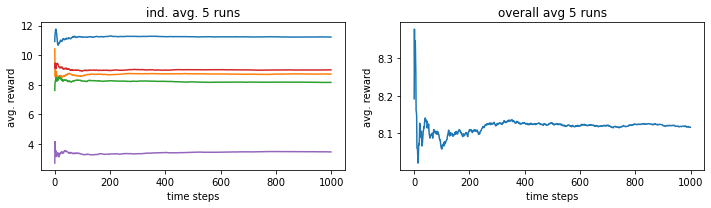

In [64]:
over_all_r_hist = run_k_bandit_x_times(greedy_policy, None, 
                                       5, n_steps, k)
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.title('ind. avg. 5 runs')

for i in range(5):
    
    plt.plot(np.cumsum(over_all_r_hist[:,i]) / range(1,n_steps+1))

plt.ylabel('avg. reward')    
plt.xlabel('time steps') 

plt.subplot(1,2,2)
plt.title('overall avg 5 runs')

plt.plot(np.mean(np.cumsum(over_all_r_hist, axis=0),axis=1) /\
                 range(1,n_steps+1))


plt.ylabel('avg. reward')    
plt.xlabel('time steps') 
plt.tight_layout()
plt.show()

**1e**. In an **$\epsilon$-greedy strategy**, we select the greedy action most of the time, but sometimes (i.e. with a small probability $\varepsilon$, we will select a random action. 

* Initialize $Q_{t}(a)$ by sampling from the unit normal distribution $\mathcal N(0, 1)$.   

* At each time step, select an action and observe the reward  according to the $\epsilon$-greedy strategy. Then, update your estimate $Q_{t}(a)$. Implement a $\epsilon$-greedy strategy by selecting a random action with probability $\epsilon$ and the optimal action otherwise. Do this for 1000 steps. Save the reward for each step. 

* Repeat the above steps 5 times. For each run, plot the average reward vs. time (x-axis: time, y-axis: average reward, which is the total reward divided by the number of time steps so far)  

* Average the average reward traces across runs into 1 grand-mean reward trace across time. We'll use this to compare the performance of different policies.  

*  Repeat this for  $\epsilon=0.01, 0.1, 0.5$.  

<font color="red"> Your answer in code </font>

* For what value of $\epsilon$ is an $\epsilon$-greedy strategy equivalent to a greedy strategy?  

<font color="red"> $\epsilon$=0 means that with probability $p=0$ the agent will take a random action, i.e. it acts greedily. </font>


* For what value of $\epsilon$ is an $\epsilon$-greedy strategy equivalent to a random strategy (where you select actions at random)?  

<font color="red"> $\epsilon$=1 means that with probability $p=1$ the agent will take a random action, i.e. it acts fully randomly.  </font>


* Plot the grand mean reward trace for different values of $\epsilon$ and for the greedy policy. 
 
<font color="red"> Your answer in code </font>

* What is the best value of $\epsilon$? Why is this the case?  

<font color="red"> It seems that $\epsilon=0.01$ or $\epsilon=0$ (fully random) is the best. The best $\epsilon$ is a factor of multiple aspects of the problem, including the reward variance (the larger it is, the more exploring needed), the number of arms(the more arms, the more exploration needed), etc. The current optimal epsilon, being almost random, makes sense since all arms are drawn for the same distribution. </font>

**(9 points)**


In [71]:
def eps_greedy(Q, params):
    '''
    epsilon greedy method

    '''
    epsilon = params
    np.random.seed(None)
    p = np.random.random()
    
    if p < epsilon:
        return np.random.choice(Q.size)
    return greedy_policy(Q,params)


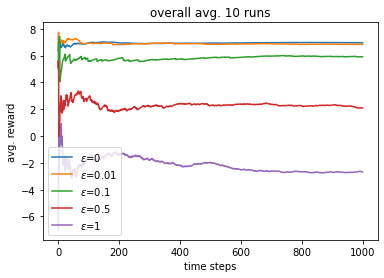

In [72]:
n_steps = 1000
k = 10
x = 10
eps_vals = [0, .01, .1, .5, 1]

plt.title('overall avg. 10 runs')

for eps_i, eps in enumerate(eps_vals):    

    over_all_r_hist_e_g = run_k_bandit_x_times(eps_greedy, eps, 
                                       x, n_steps, k)
    
    plt.plot(np.cumsum(over_all_r_hist_e_g[:,i]) / range(1,n_steps+1),
            label=r'$\epsilon$={}'.format(eps))


plt.ylabel('avg. reward'.format(eps))    
plt.xlabel('time steps') 

plt.legend()
plt.show()

**1f**. Discuss a  situation in your life that can be accurately modeled using a bandit problem. **(1 points)**

<font color="red">A bandit problem is a one-state MDP, thus - we can model decision making where one does not 'progres' through states: for example - choosing a series of drinks at a bar in order to determine the best one. Every order you are facing with the same menu, and after you order, you can update the value of each drink. if you explore and try all of them, you can reach a global optimum, but you exploit and keep ordering the current 'best' you could end up in a local optimum.</font>

* Discuss 2 decision making problems that cannot be modeled using a bandit problem and why. **(2 points)**

<font color="red"> Navigation is a classic example where there are multiple states (and possible non-markovian since it is most likely path-dependent). Thus a bandit problem would not be the correct model. Another example is a student's possible decision to procrastinate or work on a pset - moving between the pset to scroll social media or making a snack - all are different states which can be valued. </font>


# Question 2:  Finite Markov Decision Processes


In this question, we will develop the formalism of a Markov Decision
Process (MDP), which is a model of an agent interacting with an environment with some extra conditions.  The learner and decision maker is called the **agent**.  The agent  interacts with  the **environment**, which can be modeled as having a set of states $\mathcal S$, but at time $t$ its state is $S_t\in \mathcal S$. Having observed this, the agent selects an action $A_t$. In response to the agent's action $A_t$, the environment emits a numerical reward $R_{t+1}$ and moves to a new state $S_{t+1}\in \mathcal S$ 

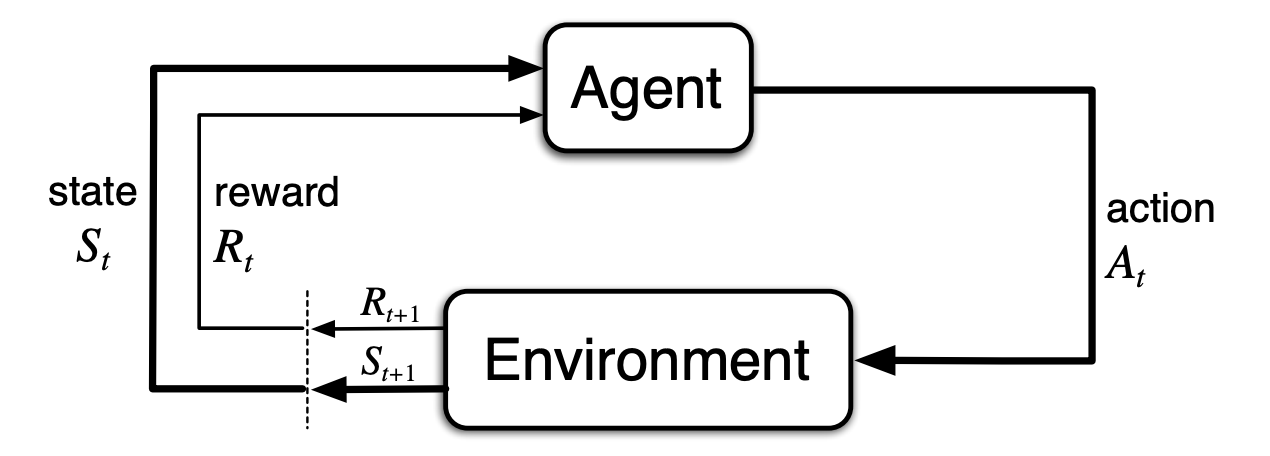

In a finite MDP, the set of possible states, actions, and rewards $(\mathcal{S}, \mathcal{A}$, and $\mathcal{R})$ all have a finite number of elements. Then,  the random variables $R_{t}$ and $S_{t}$ have well defined discrete probability distributions dependent only on the preceding state and action. More explicitly, you can imagine that the reward $R_t$ can depend on the entire trajectory of states and actions you take (e.g. In a video game, you only win when you've visited all the levels in a specific way). However, in an MDP, we assume that the current reward $R_t$ and next state $S_{t+1}$ have a joint probability distribution that depends only on the current state and action. This is called the **Markov property** and where the MDP derives its name. 
$$P\left(s^{\prime}, r \mid s, a\right) =\operatorname{P}\left\{S_{t}=s^{\prime}, R_{t}=r \mid S_{t-1}=s, A_{t-1}=a\right\}$$

Suppose a mouse is navigating a 7 by 7 rectangular grid in search of a juice reward (converted to a numerical quantity). At every cell in the grid, the mouse can choose to go in 4 directions: up, down, left, or right, which  moves the mouse to the cell in the corresponding direction. If the mouse is at an edge cell, actions that go off the grid do nothing to the mouse's position, but gives a reward of -5. If the mouse is not at the goal state (but still inside the grid), it receives a reward of -1. The mouse always starts at the upper left, and when it reaches the bottom right, it receives a reward of +100 and the mouse is then moved back to the start position. In the middle of the grid, the central cell is a false goal. If the mouse reaches this cell, it receives a reward of +10, but is moved back to the start position (i.e. instead of the usual reward of -1).

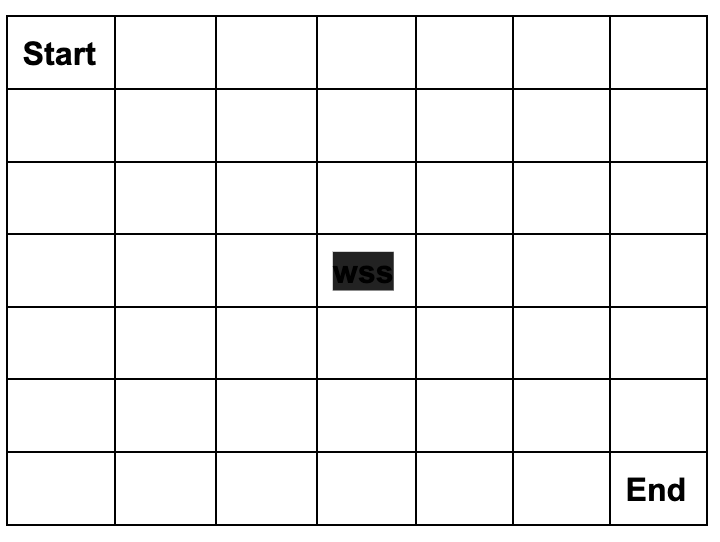

**2a**. What are the states of this reinforcement learning problem? Is this problem an MDP? Why? **(2 points)**

<font color="red"> Each cell on the grid is a state, so 49 states. This gridworld problem is an MDP. (1) it has a finite number of A (4 possible actions), S(49 states), R ($\in$ (-1,-5,+100)). The reward is then dependent only on the most recent state, action pair and not on the full path.</font>



**2b**. A useful concept in MDPs is the value function. The value function is the expected long-term return of starting at a certain state $s$ while following a policy $\pi$
$$v_{\pi}(s) = \mathbb{E}_{\pi}\left[G_{t} \mid S_{t}=s\right]$$

$G(t)$ is the long-term return of the agent, defined by
$$ G_t=R_t+\gamma R_{t+1}+\gamma^2 R_{t+2} + \ldots$$
where $\gamma$ is a discount factor which we will set to 0.95 (so that the future is discounted by 5%).

Note that the value function of a state is dependent on the policy, so that what you decide to do overall can influence the values of states. i.e. The values of states are not an intrinsic property of the world, but they depend on what you decide to do. This is what makes credit assignment so difficult. 

Given a certain policy, TD learning is a way to estimate the value of a state $V(S_t)$ (encountered at time $t$) so that
$ V(S_t) \approx v_{\pi}(S_t)$

By definition, the TD estimate is
$$V\left(S_{t}\right) \leftarrow V\left(S_{t}\right)+\alpha\left[R_{t+1}+\gamma V\left(S_{t+1}\right)-V\left(S_{t}\right)\right]$$
where $\leftarrow$ is the assignment operator, $R_{t+1}$ is the reward observed after time $t$, $S_{t+1}$ is the state observed after time $t$, $\alpha$ is a step size parameter (which we will set to 0.01)

* Let us consider the random policy: Suppose the mouse selects actions at random with uniform probability of 1/4 at every cell. 
* Initialize a random $7\times 7$ matrix $V$ that will hold the estimated values for each state. 

* Use TD learning to estimate the value of all states according to the random policy. Do this for 50000 time steps. A movement from one cell to the next counts as one time step. Store the reward received each time step. 

* Repeat the above 2 steps 5 times. Plot the average reward against time step (x-axis: time step (one movement from cell to adjacent cell) , y-axis: average reward = total reward received so far divided by number of time steps so far). You should have 5 lines here, one line for each simulation.  Save this somewhere. We'll use this to compare between different policies later. 

* For each run, visualize the values of each state under the random policy using `imshow`. 

<font color="red"> Your answer in code </font>

* Describe the plot you see regarding the values of each state. Do these values make sense, given that we're using the random policy? What about the value of the false goal? How does its value compare to the value of the surrounding states? Why is this the case?  

<font color="red"> Yes, in a stable world - a completely random policy will explore the full state space and thus is likely to converge on a good approximation of the true values (if given enough time). The values of most states are negative (as they should be), and the edge states are larger in magnitude. The false goal state is positive, and so is the value of the true goal. However, the neighboring states of the goal states have the highest value. The reason is that they are the ones leading to the reward. The goal state itself sends the agent back to the stat state (further from potential reward).</font>


**(8 points)**


In [73]:
random_policy = lambda params: np.random.choice(4)
gridworld_size = 7

start_state = (0,0)
goal_state = (6,6)
false_goal_state = (3,3)

goal_reward = 100
false_goal_reward = 10
other_reward = -1
edge_reward = -5

alpha = .01
gamma = .9

n_trials = 50000

def get_reward(status):
    '''
    get reward according to state
    '''
    if status == "goal":
        return goal_reward
    elif status == "false_goal":
        return false_goal_reward
    elif status == "edge":
        return edge_reward
    elif status == "other":
        return other_reward
        
        
actions = ['up', 'down', 'left', 'right']

def get_next_state_and_status(state, action):
    '''
    action: up, down, left, right
    '''
    if action == 'up':
        state_tag = (state[0] - 1, state[1])
    elif action == 'down':
        state_tag = (state[0] + 1, state[1])
    elif action == 'left':
        state_tag = (state[0], state[1] - 1)
    elif action == 'right':
        state_tag = (state[0], state[1] + 1)
        
    # if in the gridworld
    if (state_tag[0] >= 0) and (state_tag[0] < gridworld_size)\
        and (state_tag[1] >= 0) and (state_tag[1] < gridworld_size):
        
        # in goal state
        if (state_tag[0] == goal_state[0]) and (state_tag[1] == goal_state[1]):
            return start_state, 'goal'
    
        elif (state_tag[0] == false_goal_state[0]) and (state_tag[1] == false_goal_state[1]):
            return start_state, 'false_goal'
        
        else:
            return state_tag, 'other'
    
    # if not, maintain state, retuen edge status
    return state, 'edge'

def TD_update(v, s, s_tag, r, alpha, gamma):
    
    return alpha * (r + (gamma*v[s_tag]) - v[s])
        

In [79]:
def play(seed, n_trials=n_trials, policy=random_policy, e=None,  learning_params=[alpha, gamma], return_hist=False,):
    
    V = np.random.uniform(size=(gridworld_size, gridworld_size))
    s = start_state
    
    r_hist = []
    s_hist_sum = np.zeros((gridworld_size, gridworld_size))
    action_hist = []
    
    for trial in range(n_trials):
        
        #get action
        a = policy([V, s, e])
        action_hist.append(actions[a])
        
        # get next state
        s_tag, status = get_next_state_and_status(s, actions[a])
        s_hist_sum[s_tag]+=1
        
        #get reward
        r = get_reward(status)
        r_hist.append(r) 
        
        # update v
        alpha, gamma = learning_params
        V[s] += TD_update(V, s, s_tag, r, alpha, gamma)
        
        # update state 
        s=s_tag 
        
    if return_hist:
        return V,  r_hist, s_hist_sum, action_hist  
    
    return V,  r_hist  
        

In [80]:
random_p = {'v':[],
            'r':[],
           's':[]}


for i in range(5):
    V,  r_hist, s_hist, _  = play(i, n_trials, random_policy, None, [alpha, gamma], True)
    random_p['v'].append(V)
    random_p['r'].append(r_hist)
    random_p['s'].append(s_hist)
    

In [81]:
# im=plt.imshow(np.mean(random_p['s'],0))
# plt.colorbar(im)

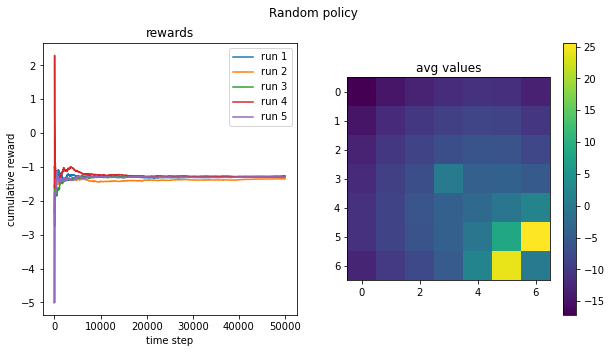

In [83]:
fig,ax = plt.subplots(1,2, figsize=(10,5))

plt.suptitle('Random policy')
for i in range(5):
    ax[0].set_title('rewards')
    r = np.cumsum(random_p['r'][i] ) / range(1,n_trials+1) 
    ax[0].plot(r, label='run {}'.format(i+1))
    ax[0].set_ylabel('cumulative reward')
    ax[0].set_xlabel('time step')
    ax[0].legend()

ax[1].set_title('avg values')
im = ax[1].imshow(np.mean(random_p['v'],0))

fig.colorbar(im, ax=ax[1])
plt.show()

**2c**. Now, let us consider the greedy policy. At each state, choose the action that will result in the best possible following state.

* Initialize a random $7\times 7$ matrix $V$ that will hold the estimated values for each state.  

* Use TD learning to estimate the value of all states according to the greedy policy. Do this for 50000 time steps. Store the reward received each time step.  

* Repeat the above 2 steps 5 times. Plot the average reward against time step (x-axis: time step (one movement from cell to adjacent cell), y-axis: average reward = total reward divided by number of time steps so far). You should have 5 lines here, one line for each simulation.  Save this somewhere. We'll use this to compare between different policies later.  

* For each simulation, visualize the values of each state under the random policy using `imshow`. 

<font color="red"> Your answer in code </font>

* Describe the plot you see regarding the values of each state. Do these values make sense, given that we're using the greedy policy?

<font color="red"> Greedy policy exploits. Thus, it does not fully learn the state space and has no opportunity to develop proper state values. See the graph below on state visit counts comparing random (explore) and greedy (exploit) policies. The values we see make sense, especially given knowing that the states with noninitial values are the only ones visited.</font>

**(6 points)**



In [84]:
# get states neighbor
get_neighbors = lambda s: [(max(s[1]-1,0),s[1]), #up
                           (min(s[1]+1,gridworld_size-1),s[1]), #down
                           (s[0],max(s[1]-1,0)), #left
                           (s[0],min(s[1]+1,gridworld_size-1))] #right

# get the value for each neighbor
get_neighbors_value = lambda v, s: [v[s] for s in get_neighbors(s)]
 
# return arg max action 
greedy_policy = lambda params: np.argmax(get_neighbors_value(params[0], params[1]))


In [85]:
greedy_p = {'v':[],
            'r':[],
            's':[]}


for i in range(5):
    V,  r_hist, s_hist, _  = play(i, n_trials, greedy_policy, None, [alpha, gamma], True)
    greedy_p['v'].append(V)
    greedy_p['r'].append(r_hist)
    greedy_p['s'].append(s_hist)

    

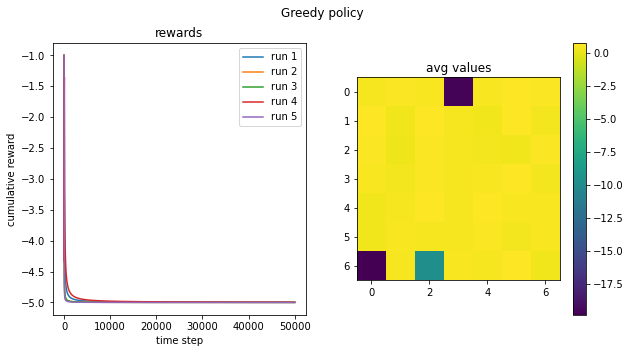

In [87]:
fig,ax = plt.subplots(1,2, figsize=(10,5))

plt.suptitle('Greedy policy')
for i in range(5):
    ax[0].set_title('rewards')
    r = np.cumsum(greedy_p['r'][i] ) / range(1,n_trials+1) 
    ax[0].plot(r, label='run {}'.format(i+1))
    ax[0].set_ylabel('cumulative reward')
    ax[0].set_xlabel('time step')
    ax[0].legend()

ax[1].set_title('avg values')
im = ax[1].imshow(np.mean(greedy_p['v'],0))

fig.colorbar(im, ax=ax[1])
plt.show()

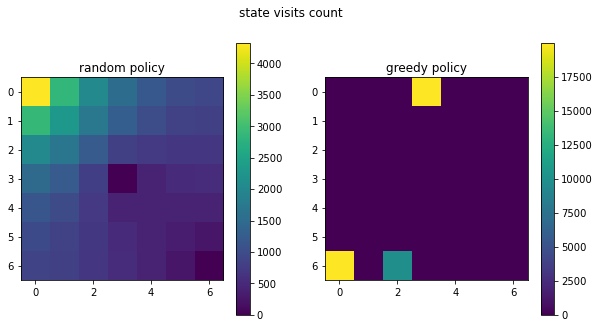

In [88]:
fig,ax = plt.subplots(1,2, figsize=(10,5))
plt.suptitle('state visits count')

ax[0].set_title('random policy')
ax[1].set_title('greedy policy')

im0=ax[0].imshow(np.mean(random_p['s'],0))
im1=ax[1].imshow(np.mean(greedy_p['s'],0))
plt.colorbar(im0, ax=ax[0])
plt.colorbar(im1, ax=ax[1])

**2d**. Now, let us consider the $\epsilon$-greedy policy. At each state, with a probability $\epsilon=0.1$, choose a random action, otherwise choose the action that will result in the best possible following state.

* Initialize a random $7\times 7$ matrix $V$ that will hold the estimated values for each state.  

* Use TD learning to estimate the value of all states according to the $\epsilon$-greedy policy. Do this for 50000 time steps. Store the reward received each time step.  

* Repeat the above 2 steps 5 times. Plot the average reward against time step (x-axis: time step (one movement from cell to adjacent cell), y-axis: average reward = total reward divided by number of time steps so far). You should have 5 lines here, one line for each simulation.  Save this somewhere. We'll use this to compare between different policies later.  
* For each simulation, visualize the values of each state under the random policy using `imshow`. 

<font color="red"> Your answer in code </font>

* Describe the plot you see regarding the values of each state. Do these values make sense, given that we're using the greedy policy? 

<font color="red"> The state value map makes sense. We see that most states maintain their initial value of 0, and only a few were actually visited and updated. The state visit count above explains that showing that most states were not visited at all according to an exploitative, greedy policy. </font>

* Repeat the above steps for $\epsilon=0.01, 0.1, 0.5$  

<font color="red"> Your answer in code </font>


**(7 points)**

In [89]:
def e_greedy_policy(params):
    '''
    epsilon greedy method

    '''
    v, s, epsilon = params
    np.random.seed(None)
    
    p = np.random.random()
    
    if p < epsilon:
        return random_policy(params)
    return greedy_policy(params)


In [90]:
e_greedy_p = {0:{'v':[],'r':[]},
             0.01:{'v':[],'r':[]},
             0.1:{'v':[],'r':[]},
             0.5:{'v':[],'r':[]},
             1:{'v':[],'r':[]},}

for e in [0, 0.01,0.1,0.5,1]:
    for i in range(5):
        V,  r_hist  = play(i, n_trials, e_greedy_policy, e, [alpha, gamma], False)
        e_greedy_p[e]['v'].append(V)
        e_greedy_p[e]['r'].append(r_hist)


**2e**. For each policy (random, greedy, 0.01-greedy, 0.1-greedy, 0.5-greedy), average the average rewards vs. time across the 5 runs. 
* Plot these for each policy (x-axis: first 3000 time steps, y-axis: average reward).

<font color="red"> Your answer in code </font>

* Which policy is the best? Why do you think this is the case? **(2 points)**

<font color="red"> e=0.5 seems to be the best. It is probably due to a good balance of exploration and exploitation.</font>

* What do you notice about the dynamics of each policy? Which policy performs the best early on, in the middle, and at the end? **(2 points)**

<font color="red"> e=0 seems to start well but quickly falls, as it does not act on the knowledge gained and evaluation of states when making the decision (e=0, random policy) and e=1 starts really bad and improves a lot but not enough to optimize the overall reward (according to local optimum convergence which makes sense with a greedy policy). The e greedy (e=0.5, 0.1) algorithms seem to improve at a better rate- and the e=.5 happens to be the best in this example. </font>


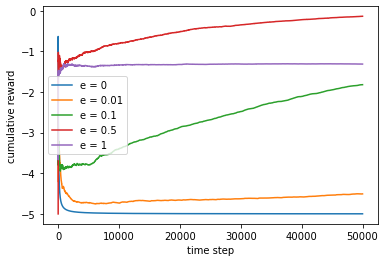

In [115]:
r_e = np.zeros((5, n_trials))
for e_i, e in enumerate([0, 0.01, 0.1, 0.5, 1]):
    r_tmp = np.zeros((5, n_trials))
    for i in range(5):
        r = np.cumsum(e_greedy_p[e]['r'][i] ) / range(1,n_trials+1)
        r_tmp[i] = r
        
    r_e[e_i] = np.mean(r_tmp, 0)     
        
    plt.plot(r_e[e_i], label='e = {}'.format(e))
plt.legend()
plt.ylabel('cumulative reward')
plt.xlabel('time step')
plt.show()

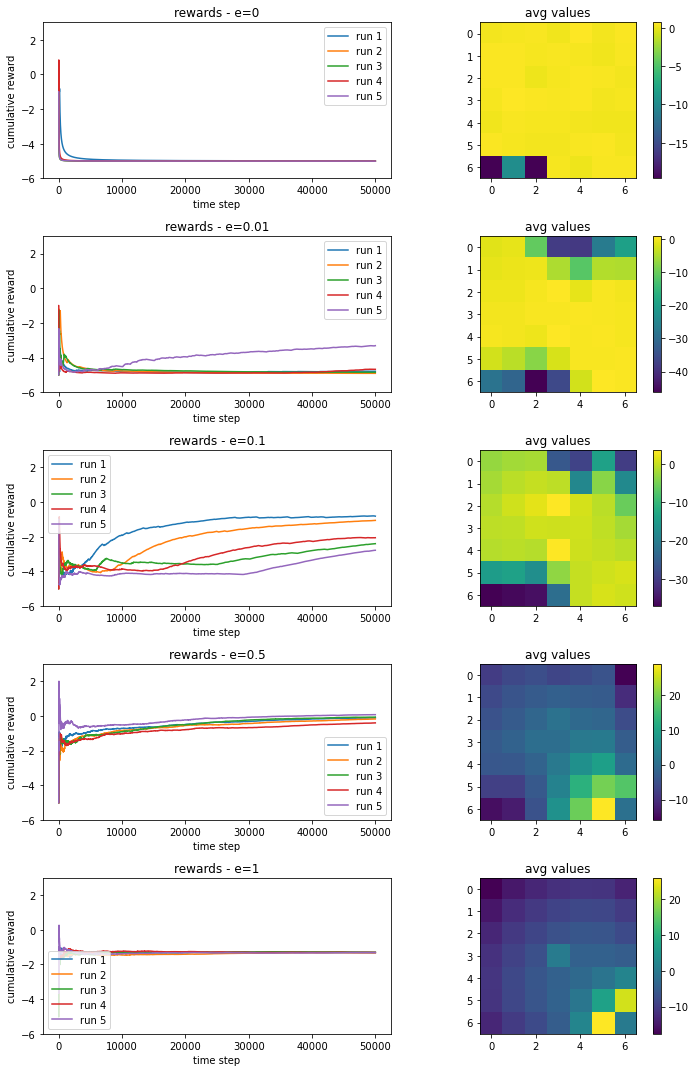

In [110]:
fig,ax = plt.subplots(5,2, figsize=(10,15))

for e_i, e in enumerate([0, 0.01, 0.1, 0.5, 1]):

    for i in range(5):
        ax[e_i][0].set_title('rewards - e={}'.format(e))
        r = np.cumsum(e_greedy_p[e]['r'][i] ) / range(1,n_trials+1) 
        ax[e_i][0].plot(r, label='run {}'.format(i+1))
        ax[e_i][0].set_ylabel('cumulative reward')
        ax[e_i][0].set_xlabel('time step')
        ax[e_i][0].legend()
        ax[e_i][0].set_ylim(-6, 3)
    
    ax[e_i][1].set_title('avg values')
    im = ax[e_i][1].imshow(np.mean(e_greedy_p[e]['v'],0))

    fig.colorbar(im, ax=ax[e_i][1])

plt.tight_layout()
plt.show()

**2f**. Now suppose that $\gamma=0.001$. For each policy (random, greedy, 0.01-greedy, 0.1-greedy, 0.5-greedy), compute the average rewards vs. time across 5 runs. 
* Plot these for each policy (x-axis: first 3000 time steps, y-axis: average reward).

<font color="red"> Your answer in code </font>

* How does decreasing the $\gamma$ parameter affect the behavior of the mouse? Support this answer by plotting the values of each state. **(2 points)** 

<font color="red"> gamma is the parameter of future discounting. If $\gamma$ is closer to zero, the model considers only immediate rewards, and when $\gamma$ is closer to 1, it will consider future rewards (i.e delay the reward). Reducing $\gamma$ made all algorithms more greedy. thus, making e=.5 'closer' to a greedy algorithm (e=1); So a lower e (further from greedy) is now optimal. </font>

* Which policy is the best now? Why do you think this is the case? **(2 points)**

<font color="red"> the greedy/random  policies are still sub-optimal. It seems that e greedy with e=0.1 will be the optimal policy if we ran the model for long enough. While e=0.5 shows a higher reward, it seems to have reached convergence while e=0.1 is still climbing. This</font>

* Now, what do you notice about the dynamics of each policy? Which policy performs the best early on, in the middle, and at the end? How does this compare with the case when $\gamma=0.95$? **(2 points)**

<font color="red"> it seems that there is a clearer bifurcation of the policies - higher epsilons resemble e=1 more and lower ones resemble e=0 more. so only e=0.1 shows a proper improvement rate, unlike before when all epsilon greedy algorithms were improving. </font>


In [117]:
e_greedy_p_gamma001 = {0:{'v':[],'r':[]},
             0.01:{'v':[],'r':[]},
             0.1:{'v':[],'r':[]},
             0.5:{'v':[],'r':[]},
             1:{'v':[],'r':[]},}

for e in [0, 0.01,0.1,0.5,1]:
    for i in range(5):
        V,  r_hist  = play(i, n_trials, e_greedy_policy, e, [alpha, 0.001], False)
        e_greedy_p_gamma001[e]['v'].append(V)
        e_greedy_p_gamma001[e]['r'].append(r_hist)

        

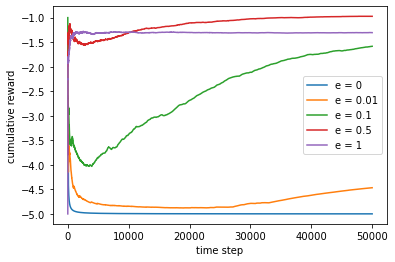

In [118]:
r_e001 = np.zeros((5, n_trials))
for e_i, e in enumerate([0, 0.01, 0.1, 0.5, 1]):
    r_tmp = np.zeros((5, n_trials))
    for i in range(5):
        r = np.cumsum(e_greedy_p_gamma001[e]['r'][i] ) / range(1,n_trials+1)
        r_tmp[i] = r
        
    r_e001[e_i] = np.mean(r_tmp, 0)     
        
    plt.plot(r_e001[e_i], label='e = {}'.format(e))
plt.legend()
plt.ylabel('cumulative reward')
plt.xlabel('time step')
plt.show()

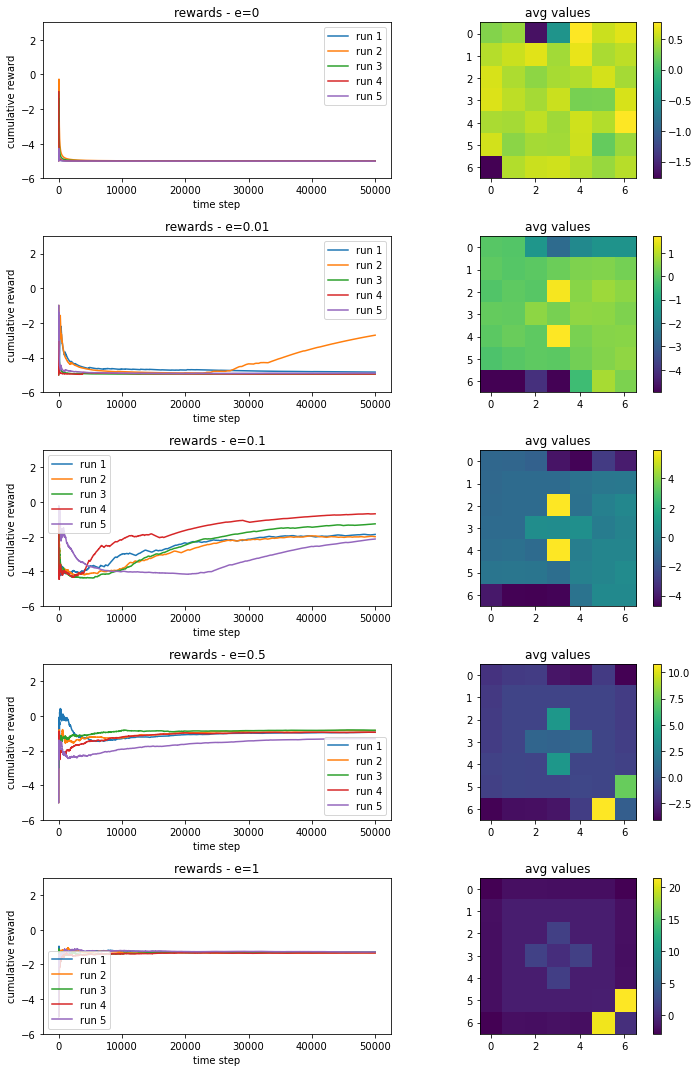

In [119]:
fig,ax = plt.subplots(5,2, figsize=(10,15))

for e_i, e in enumerate([0, 0.01, 0.1, 0.5, 1]):

    for i in range(5):
        ax[e_i][0].set_title('rewards - e={}'.format(e))
        r = np.cumsum(e_greedy_p_gamma001[e]['r'][i] ) / range(1,n_trials+1) 
        ax[e_i][0].plot(r, label='run {}'.format(i+1))
        ax[e_i][0].set_ylabel('cumulative reward')
        ax[e_i][0].set_xlabel('time step')
        ax[e_i][0].legend()
        ax[e_i][0].set_ylim(-6, 3)
    
    ax[e_i][1].set_title('avg values')
    im = ax[e_i][1].imshow(np.mean(e_greedy_p_gamma001[e]['v'],0))

    fig.colorbar(im, ax=ax[e_i][1])

plt.tight_layout()
plt.show()

**2g**. What is a weakness of the TD algorithm? Suggest 1 way to improve the performance of the TD algorithm on this task. **(2 points)**

<font color="red"> I think that a Q table that maintains values for a state, action pair- rather than a state alone could improve the performance. Specifically, given that the goal is an edge state and could be avoided if not considering the best action to take from it </font>


